## Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing data

In [2]:
dfc = pd.read_csv("modelling.csv", encoding= 'UTF-8',delimiter =';')
dfc.head()

,date,Unnamed: 0,day,month,year,prod,und,proc,tipo,min,mcom,max,merc,mm,Full_date
0,2013-01-02,678,2,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,2-1-2013
1,2013-01-03,1442,3,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,3-1-2013
2,2013-01-04,2264,4,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,4-1-2013
3,2013-01-07,4699,7,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,7-1-2013
4,2013-01-08,5464,8,1,2013,Peixe de agua salgada,Kg,RS-SC,Sardinha,4.38,4.98,5.28,Est,0.9,8-1-2013


In [3]:
dfc['date'] = pd.to_datetime(dfc['date'])

## Creating new dataframes for modelling

In [4]:
#Creating new dataframes and renaming the columns according with the Fb-Prophet 
# specifications

dfm = dfc[["date","max"]]
dfm = dfm.rename(columns = {"date":"ds","max":"y"}) 
dfmin = dfc[["date","min"]]
dfmin = dfmin.rename(columns = {"date":"ds","min":"y"}) 
dfmc = dfc[["date","mcom"]]
dfmc = dfmc.rename(columns = {"date":"ds","mcom":"y"}) 

## Max modelling

In [5]:
len(dfm)

2253

In [6]:
# Spliting the dataset into train and test
train = dfm[:2133]
test = dfm[2133:]

In [7]:
print(len(train))
print(len(test))

2133
120


In [8]:
m_max=Prophet(growth = "linear", 
          seasonality_mode = "additive", 
    weekly_seasonality= False, 
    daily_seasonality=True,
    yearly_seasonality=True,
)
m_max.add_country_holidays(country_name="Brazil") #adding holidays
m_max.fit(train) #fitting models
future=m_max.make_future_dataframe(periods=365) #periods according to autocorrelation
forecast_m=m_max.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/ub01so3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/1_ygx2pv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91743', 'data', 'file=/tmp/tmpqgk2y5cv/ub01so3m.json', 'init=/tmp/tmpqgk2y5cv/1_ygx2pv.json', 'output', 'file=/tmp/tmpvxkaoces/prophet_model-20220819150546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
df_cv = cross_validation(m_max, initial='2133 days', horizon = '365 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2018-12-22 00:00:00 and 2020-12-21 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/tfkskmck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/9xgw5y07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40795', 'data', 'file=/tmp/tmpqgk2y5cv/tfkskmck.json', 'init=/tmp/tmpqgk2y5cv/9xgw5y07.json', 'output', 'file=/tmp/tmp9jbdh4n9/prophet_model-20220819150555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/qyncz86v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/4ppr54zr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

In [10]:
df_p = pd.DataFrame(performance_metrics(df_cv))
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,38 days 00:00:00,0.209283,0.457475,0.370315,0.041806,0.031336,0.041852,0.537500
1,38 days 12:00:00,0.210472,0.458772,0.371896,0.042001,0.031336,0.042056,0.533333
2,39 days 00:00:00,0.208493,0.456610,0.369468,0.041761,0.029644,0.041799,0.533333
3,39 days 12:00:00,0.211942,0.460371,0.374236,0.042277,0.031336,0.042339,0.525000
4,40 days 00:00:00,0.211255,0.459625,0.372375,0.042077,0.029949,0.042128,0.525000
...,...,...,...,...,...,...,...,...
580,362 days 12:00:00,0.591156,0.768867,0.596902,0.059140,0.056676,0.061199,0.750000
581,363 days 00:00:00,0.589445,0.767753,0.595177,0.058968,0.056676,0.061017,0.750000
582,364 days 00:00:00,0.591283,0.768949,0.597721,0.059181,0.056676,0.061237,0.750000
583,364 days 12:00:00,0.602848,0.776433,0.602721,0.059545,0.056676,0.061644,0.745833


In [11]:
train2 = df_p[:403]
train2.head()

r_mse = np.mean(train2['rmse'])
mae = np.mean(train2['mae'])
mape = np.mean(train2['mape'])

print("Mean absolute error Validation: %f"%mae)
print("Mean absolute percentage error validation: %f"%mape)
print("Root mean square error validation: %f"%r_mse)

Mean absolute error Validation: 0.479584
Mean absolute percentage error validation: 0.051224
Root mean square error validation: 0.616368


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


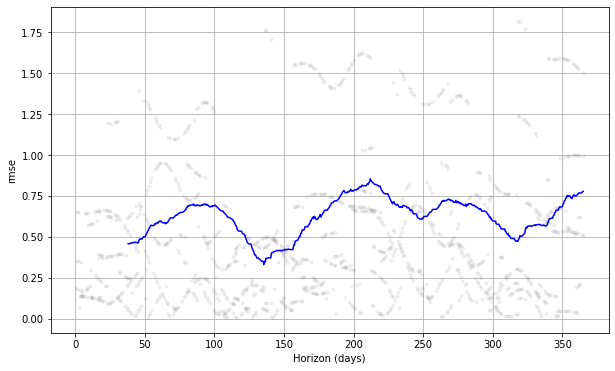

In [12]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')


In [13]:
# Checking the metrics with the test dataset
y_pred = forecast_m.iloc[2133:2253]['yhat']
y_true = test['y']
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r_mse= rmse(y_pred, y_true)
print("Mean absolute error test: %f"%mae)
print("Mean absolute percentage error test: %f"%mape)
print("Root mean square error test: %f"%r_mse)


Mean absolute error test: 1.137325
Mean absolute percentage error test: 0.114817
Root mean square error test: 1.287427


In [50]:
# Checking for the whole dataframe
y_predm = forecast_m.iloc[:2253]['yhat']
y_true = dfm['y']
mae = mean_absolute_error(y_true, y_predm)
mape = mean_absolute_percentage_error(y_true, y_predm)
rmsee= rmse(y_predm, y_true)
r_2 = r2_score(y_pred= y_predm, y_true= y_true)
print("Mean absolute error: %f"%mae)
print("Mean absolute percentage error: %f"%mape)
print("Root mean square error: %f"%rmsee)
print("R2 score: %f"%r_2)

Mean absolute error: 0.326026
Mean absolute percentage error: 0.043184
Root mean square error: 0.468556
R2 score: 0.941485


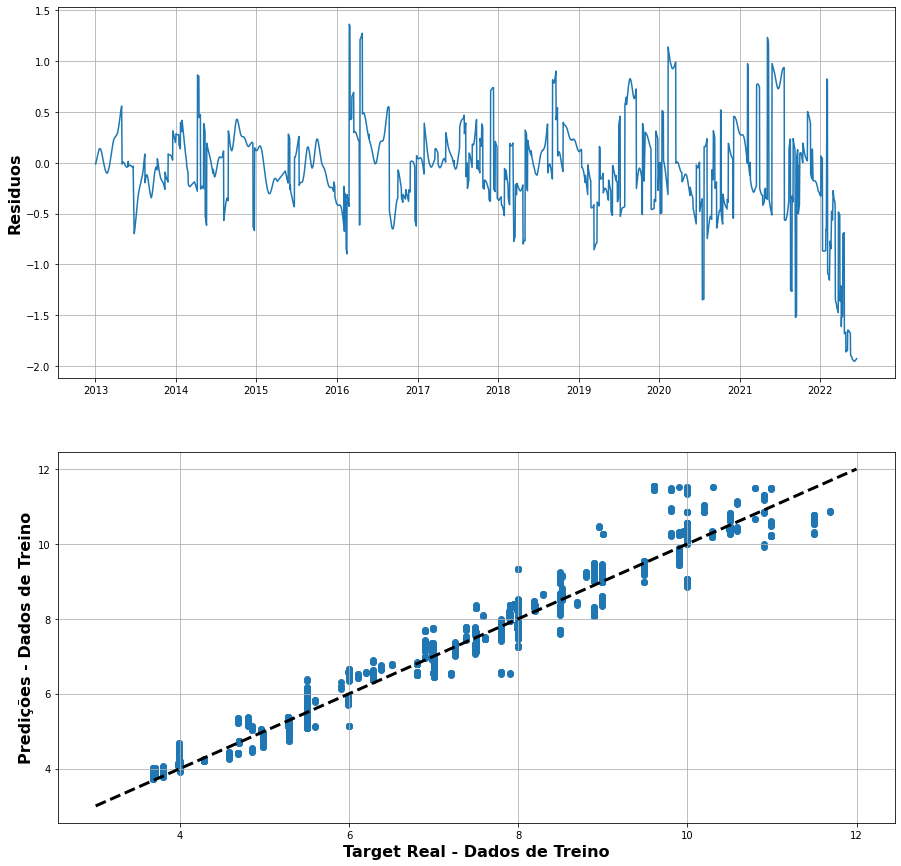

In [15]:
plt.figure(figsize=[15, 15])

plt.subplot(2, 1, 1)
plt.plot(dfm['ds'], dfm['y'] - forecast_m.iloc[:2253]['yhat'])
plt.ylabel('Residuos', fontweight='bold', fontsize=16)
plt.grid()

plt.subplot(2, 1, 2)
plt.scatter(dfm['y'], forecast_m.iloc[:2253]['yhat'])
plt.xlabel("Target Real - Dados de Treino", fontweight='bold', fontsize=16)
plt.ylabel("Predições - Dados de Treino", fontweight='bold', fontsize=16)
plt.grid()
range_line = int(np.maximum(max(dfm['y']), max(forecast_m.iloc[:2253]['yhat'])))+2
plt.plot(range(int(min(dfm['y'])), range_line), range(
    int(min(train['y'])), range_line), '--', c='black', lw=3)
plt.show()

## Mcom modelling

In [16]:
# Spliting the dataset into train and test
train = dfmc[:2133]
test = dfmc[2133:]

In [17]:
m_mc=Prophet(growth = "linear", #indicating the kind of growth
          seasonality_mode = "additive", #indicating the seasonality
    weekly_seasonality= False, 
    daily_seasonality=True,
    yearly_seasonality=True,
)
m_mc.add_country_holidays(country_name="Brazil") #adding holidays
m_mc.fit(train) #fitting models
future=m_mc.make_future_dataframe(periods=365)
forecast_mc=m_mc.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/jz4h83la.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/iby4atld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94721', 'data', 'file=/tmp/tmpqgk2y5cv/jz4h83la.json', 'init=/tmp/tmpqgk2y5cv/iby4atld.json', 'output', 'file=/tmp/tmpw2cf_7fo/prophet_model-20220819150631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:06:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
df_cvmc = cross_validation(m_mc, initial='2133 days', horizon = '365 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2018-12-22 00:00:00 and 2020-12-21 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/y05hlw8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/ih9xzanv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89482', 'data', 'file=/tmp/tmpqgk2y5cv/y05hlw8c.json', 'init=/tmp/tmpqgk2y5cv/ih9xzanv.json', 'output', 'file=/tmp/tmp2vz3mtfy/prophet_model-20220819150641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:06:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:06:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/m2onhvka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/r3ri_3x8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

In [19]:
df_pmc = pd.DataFrame(performance_metrics(df_cvmc))
df_pmc

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,38 days 00:00:00,0.977453,0.988662,0.737231,0.089700,0.077872,0.092848,0.304167
1,38 days 12:00:00,0.975804,0.987828,0.735296,0.089380,0.077754,0.092551,0.308333
2,39 days 00:00:00,1.006302,1.003146,0.750065,0.090931,0.077872,0.094246,0.300000
3,39 days 12:00:00,1.006494,1.003242,0.750373,0.090885,0.077872,0.094241,0.300000
4,40 days 00:00:00,1.008952,1.004466,0.752942,0.091215,0.078600,0.094544,0.291667
...,...,...,...,...,...,...,...,...
580,362 days 12:00:00,3.485933,1.867065,1.404951,0.153217,0.177148,0.167724,0.408333
581,363 days 00:00:00,3.485949,1.867070,1.405282,0.153262,0.177148,0.167770,0.408333
582,364 days 00:00:00,3.564904,1.888095,1.422498,0.154398,0.177148,0.169527,0.408333
583,364 days 12:00:00,3.578520,1.891698,1.430727,0.155281,0.177739,0.170507,0.404167


In [20]:
train2 = df_pmc[:403]
train2.head()

r_mse = np.mean(train2['rmse'])
mae = np.mean(train2['mae'])
mape = np.mean(train2['mape'])

print("Mean absolute error Validation: %f"%mae)
print("Mean absolute percentage error validation: %f"%mape)
print("Root mean square error validation: %f"%r_mse)

Mean absolute error Validation: 0.858848
Mean absolute percentage error validation: 0.101015
Root mean square error validation: 1.159461


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


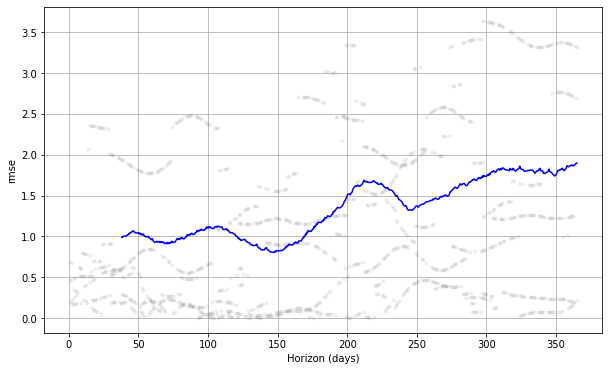

In [21]:
fig = plot_cross_validation_metric(df_cvmc, metric='rmse')


In [22]:
# Checking the metrics with the test dataset
y_pred = forecast_mc.iloc[2133:2253]['yhat']
y_true = test['y']
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r_mse= rmse(y_pred, y_true)
print("Mean absolute error test: %f"%mae)
print("Mean absolute percentage error test: %f"%mape)
print("Root mean square error test: %f"%r_mse)

Mean absolute error test: 1.335802
Mean absolute percentage error test: 0.135859
Root mean square error test: 1.462856


In [49]:
# Checking for the whole dataframe
y_predmcom = forecast_mc.iloc[:2253]['yhat']
y_true = dfmc['y']
mae = mean_absolute_error(y_true, y_predmcom)
mape = mean_absolute_percentage_error(y_true, y_predmcom)
rmsee= rmse(y_predmcom, y_true)
print("Mean absolute error: %f"%mae)
print("Mean absolute percentage error: %f"%mape)
print("Root mean square error: %f"%rmsee)


Mean absolute error: 0.346620
Mean absolute percentage error: 0.051088
Root mean square error: 0.492994


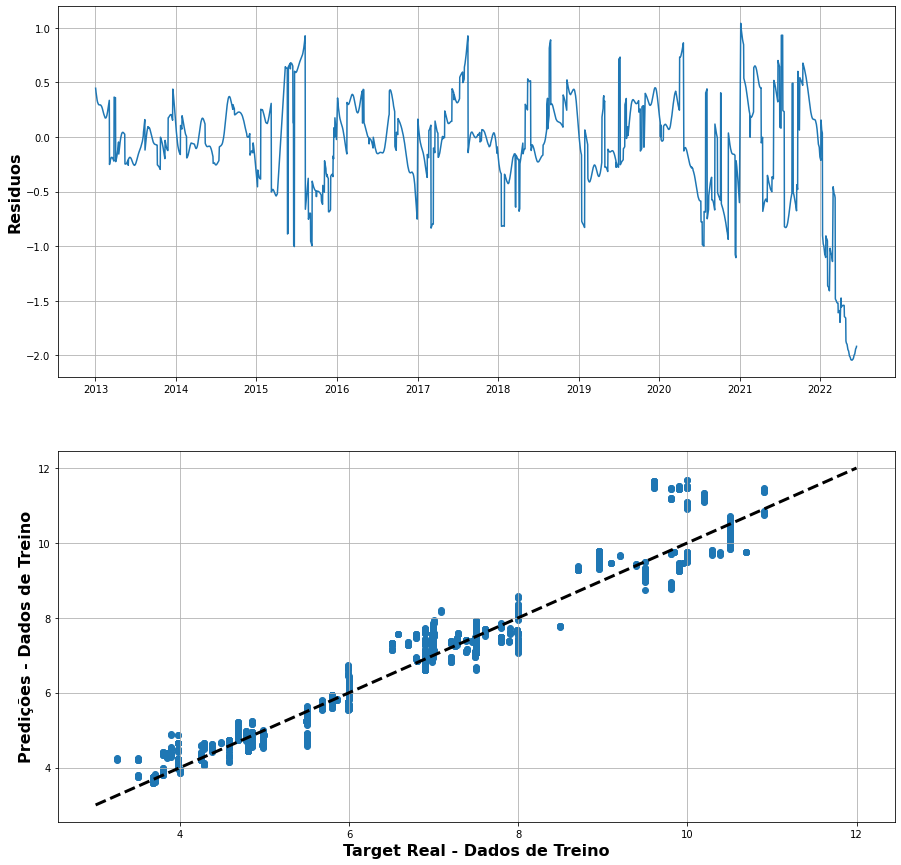

In [24]:
plt.figure(figsize=[15, 15])

plt.subplot(2, 1, 1)
plt.plot(dfmc['ds'], dfmc['y'] - forecast_mc.iloc[:2253]['yhat'])
plt.ylabel('Residuos', fontweight='bold', fontsize=16)
plt.grid()

plt.subplot(2, 1, 2)
plt.scatter(dfmc['y'], forecast_mc.iloc[:2253]['yhat'])
plt.xlabel("Target Real - Dados de Treino", fontweight='bold', fontsize=16)
plt.ylabel("Predições - Dados de Treino", fontweight='bold', fontsize=16)
plt.grid()
range_line = int(np.maximum(max(dfmc['y']), max(forecast_mc.iloc[:2253]['yhat'])))+2
plt.plot(range(int(min(dfmc['y'])), range_line), range(
    int(min(train['y'])), range_line), '--', c='black', lw=3)
plt.show()

## Min modelling

In [25]:
# Spliting the dataset into train and test
train = dfmin[:2133]
test = dfmin[2133:]

In [26]:
m_min=Prophet(growth = "linear", #indicating the kind of growth
          seasonality_mode = "additive", #indicating the seasonality
    weekly_seasonality= False, 
    daily_seasonality=True,
    yearly_seasonality=True,
)
m_min.add_country_holidays(country_name="Brazil") #adding holidays
m_min.fit(train) #fitting models
future=m_min.make_future_dataframe(periods=365)
forecast_min=m_min.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/boiqbtw0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/y1bk7gvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2623', 'data', 'file=/tmp/tmpqgk2y5cv/boiqbtw0.json', 'init=/tmp/tmpqgk2y5cv/y1bk7gvx.json', 'output', 'file=/tmp/tmpw4ota2ei/prophet_model-20220819150710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:07:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:07:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
df_cvmin = cross_validation(m_min, initial='2133 days', horizon = '365 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2018-12-22 00:00:00 and 2020-12-21 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/4on00ikj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/_dtjttme.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83937', 'data', 'file=/tmp/tmpqgk2y5cv/4on00ikj.json', 'init=/tmp/tmpqgk2y5cv/_dtjttme.json', 'output', 'file=/tmp/tmphvriv9uk/prophet_model-20220819150715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:07:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:07:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/7tca2yto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqgk2y5cv/hcq8a_73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

In [28]:
df_pmin = pd.DataFrame(performance_metrics(df_cvmin))
df_pmin

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,38 days 00:00:00,0.707325,0.841026,0.629123,0.092425,0.058334,0.090343,0.529167
1,38 days 12:00:00,0.711057,0.843242,0.632160,0.092986,0.058334,0.090808,0.525000
2,39 days 00:00:00,0.723498,0.850587,0.639619,0.093985,0.060218,0.091835,0.516667
3,39 days 12:00:00,0.729081,0.853862,0.644776,0.094861,0.061178,0.092640,0.508333
4,40 days 00:00:00,0.744558,0.862878,0.655230,0.096227,0.065171,0.094068,0.500000
...,...,...,...,...,...,...,...,...
580,362 days 12:00:00,5.239093,2.288906,1.697046,0.203842,0.233630,0.220936,0.508333
581,363 days 00:00:00,5.238897,2.288864,1.696854,0.203814,0.233630,0.220929,0.508333
582,364 days 00:00:00,5.408803,2.325683,1.721420,0.205329,0.233630,0.223947,0.508333
583,364 days 12:00:00,5.374195,2.318231,1.720760,0.205401,0.235916,0.223852,0.504167


In [29]:
train2 = df_pmin[:403]
train2.head()

r_mse = np.mean(train2['rmse'])
mae = np.mean(train2['mae'])
mape = np.mean(train2['mape'])

print("Mean absolute error Validation: %f"%mae)
print("Mean absolute percentage error validation: %f"%mape)
print("Root mean square error validation: %f"%r_mse)

Mean absolute error Validation: 1.060628
Mean absolute percentage error validation: 0.147831
Root mean square error validation: 1.239063


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


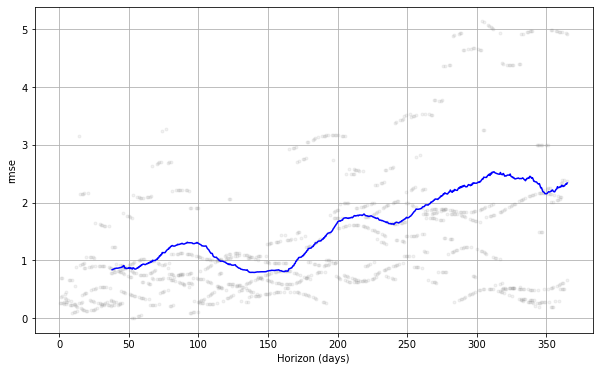

In [30]:
fig = plot_cross_validation_metric(df_cvmin, metric='rmse')


In [47]:
# Checking the metrics with the test dataset
y_pred = forecast_min.iloc[2133:2253]['yhat']
y_true = test['y']
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r_mse= rmse(y_pred, y_true)
print("Mean absolute error test: %f"%mae)
print("Mean absolute percentage error test: %f"%mape)
print("Root mean square error test: %f"%r_mse)

Mean absolute error test: 0.462903
Mean absolute percentage error test: 0.046833
Root mean square error test: 0.502414


In [48]:
# Checking for the whole dataframe
y_predmin = forecast_min.iloc[:2253]['yhat']
y_true = dfmin['y']
mae = mean_absolute_error(y_true, y_predmin)
mape = mean_absolute_percentage_error(y_true, y_predmin)
rmsee= rmse(y_predmin, y_true)
print("Mean absolute error: %f"%mae)
print("Mean absolute percentage error: %f"%mape)
print("Root mean square error: %f"%rmsee)

Mean absolute error: 0.414123
Mean absolute percentage error: 0.068354
Root mean square error: 0.544210


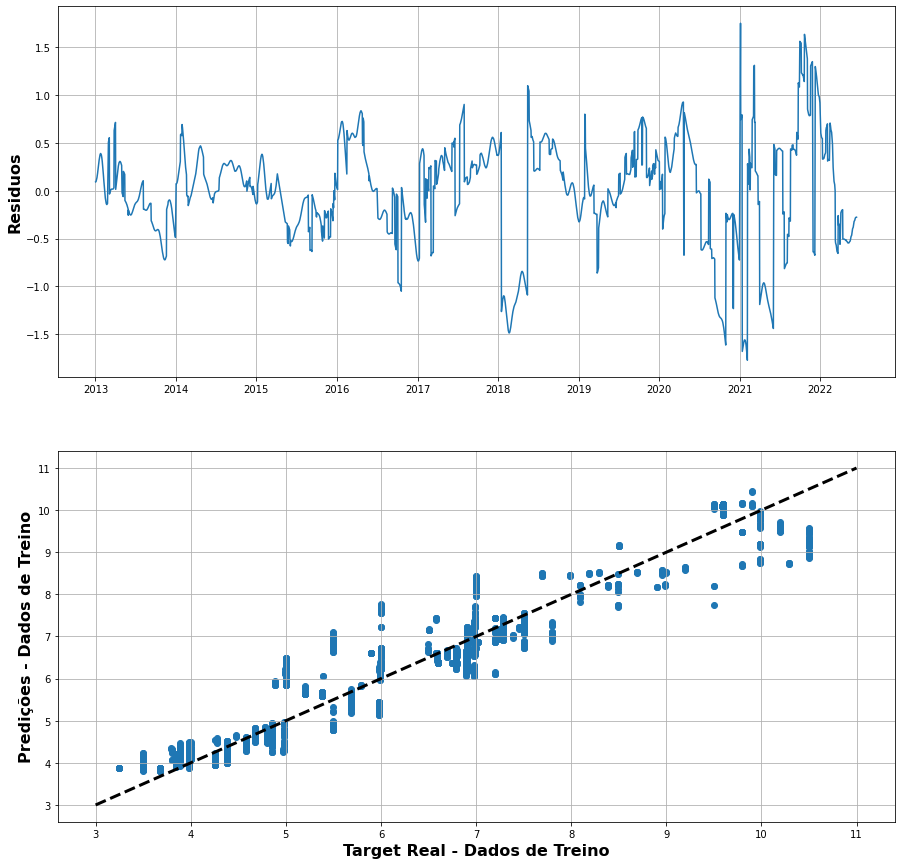

In [33]:
plt.figure(figsize=[15, 15])

plt.subplot(2, 1, 1)
plt.plot(dfmin['ds'], dfmin['y'] - forecast_min.iloc[:2253]['yhat'])
plt.ylabel('Residuos', fontweight='bold', fontsize=16)
plt.grid()

plt.subplot(2, 1, 2)
plt.scatter(dfmin['y'], forecast_min.iloc[:2253]['yhat'])
plt.xlabel("Target Real - Dados de Treino", fontweight='bold', fontsize=16)
plt.ylabel("Predições - Dados de Treino", fontweight='bold', fontsize=16)
plt.grid()
range_line = int(np.maximum(max(dfmin['y']), max(forecast_min.iloc[:2253]['yhat'])))+2
plt.plot(range(int(min(dfmin['y'])), range_line), range(
    int(min(train['y'])), range_line), '--', c='black', lw=3)
plt.show()

## Plotting graphs

### max

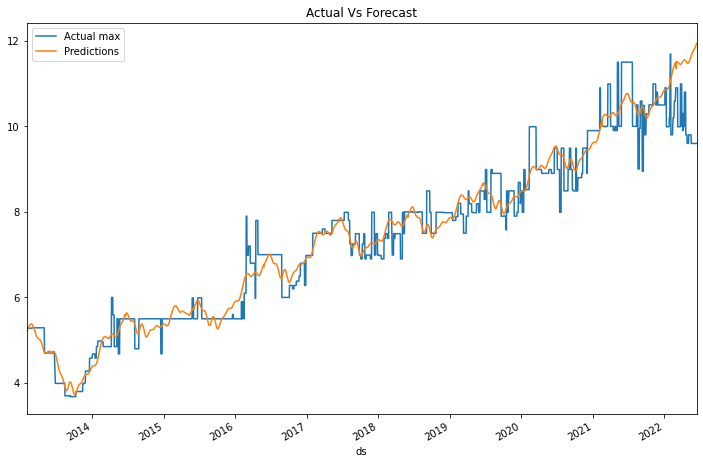

In [34]:
# plotting the actual and forecast values for maximum prices

ax = (dfm.plot(x='ds',y='y',legend=True,label='Actual max',figsize=(12,8),title='Actual Vs Forecast'))
forecast_m.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8), ax=ax,xlim=('2013-02-01','2022-06-14'))

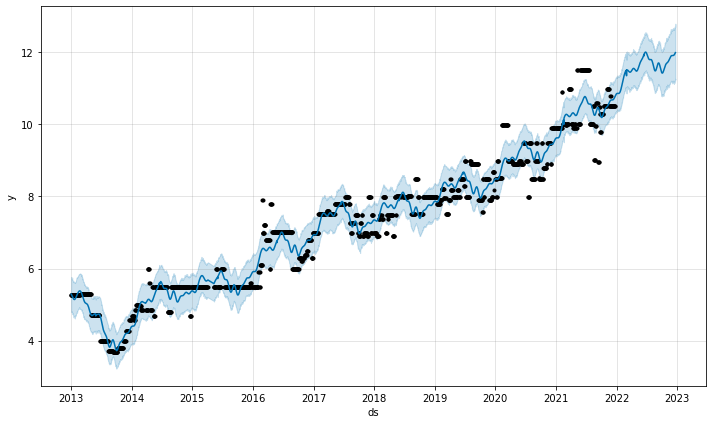

In [35]:
fig1 = m_max.plot(forecast_m, uncertainty=True)


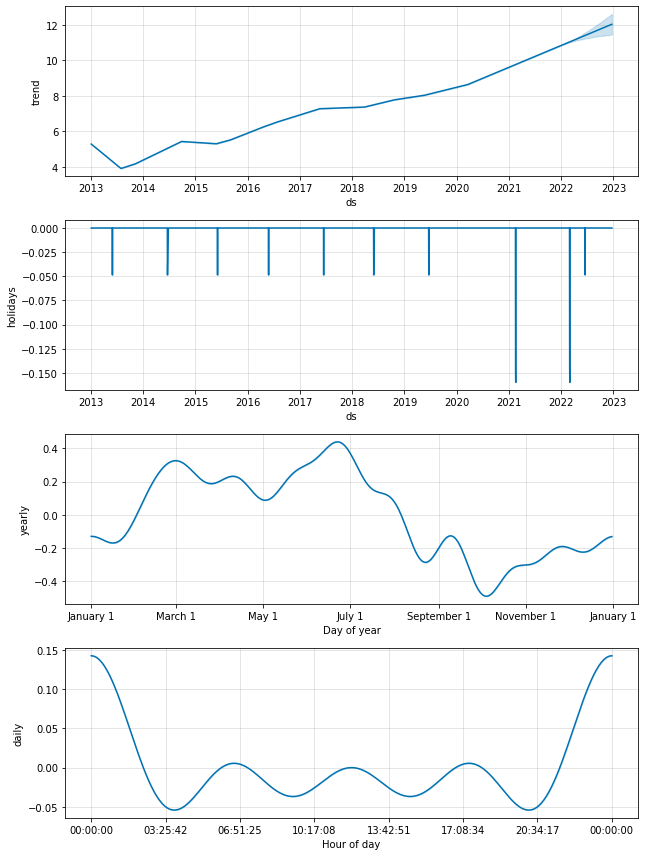

In [38]:
fig2 = m_max.plot_components(forecast_m)

### mcom

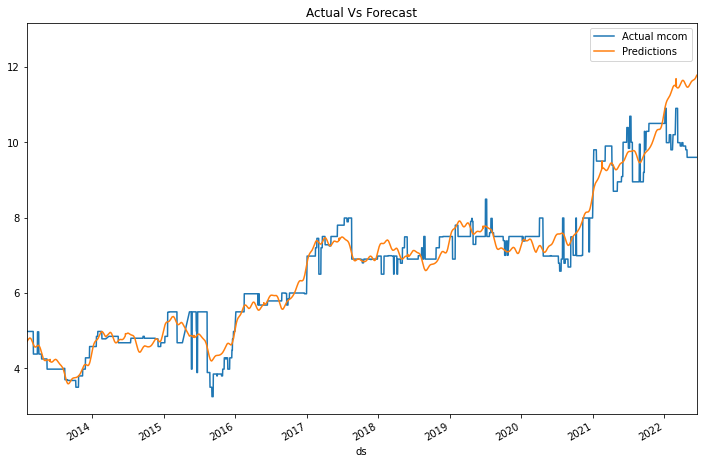

In [36]:
ax = (dfmc.plot(x='ds',y='y',legend=True,label='Actual mcom',figsize=(12,8),title='Actual Vs Forecast'))
forecast_mc.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8), ax=ax,xlim=('2013-02-01','2022-06-14'))

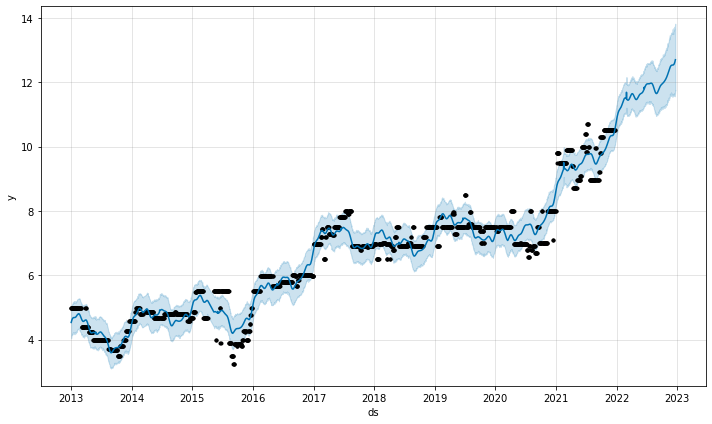

In [37]:
fig3 = m_mc.plot(forecast_mc, uncertainty=True)


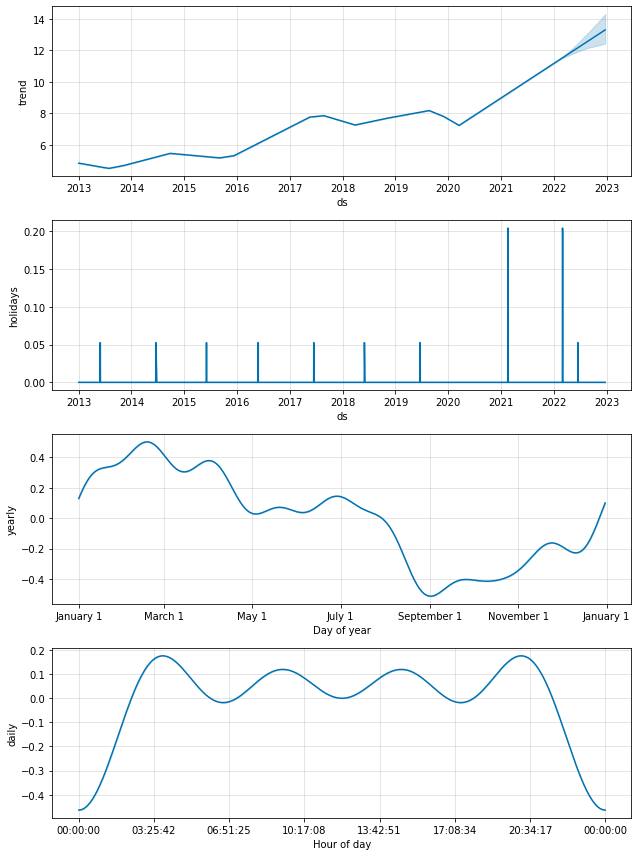

In [39]:
fig4 = m_mc.plot_components(forecast_mc)

### Min

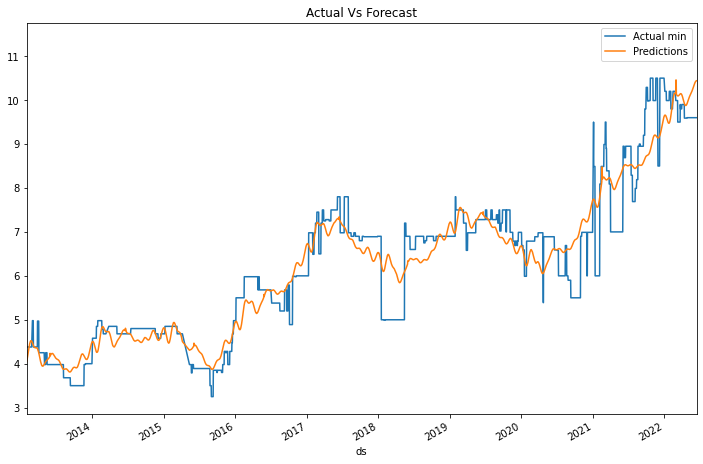

In [40]:
ax = (dfmin.plot(x='ds',y='y',legend=True,label='Actual min',figsize=(12,8),title='Actual Vs Forecast'))
forecast_min.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8), ax=ax,xlim=('2013-02-01','2022-06-14'))


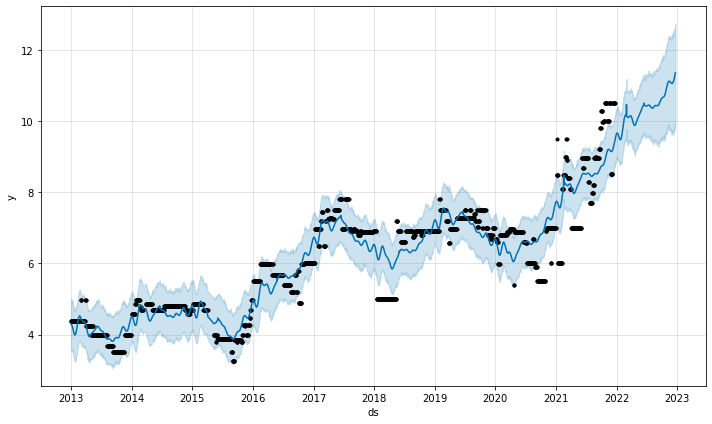

In [41]:
fig5 = m_min.plot(forecast_min, uncertainty=True)


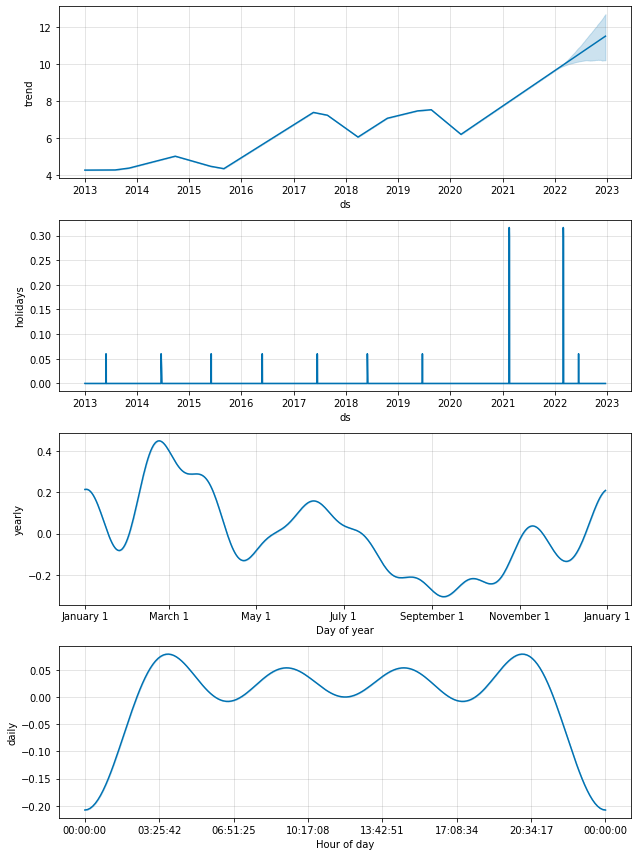

In [42]:
fig6 = m_min.plot_components(forecast_min)

### Combined

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting 

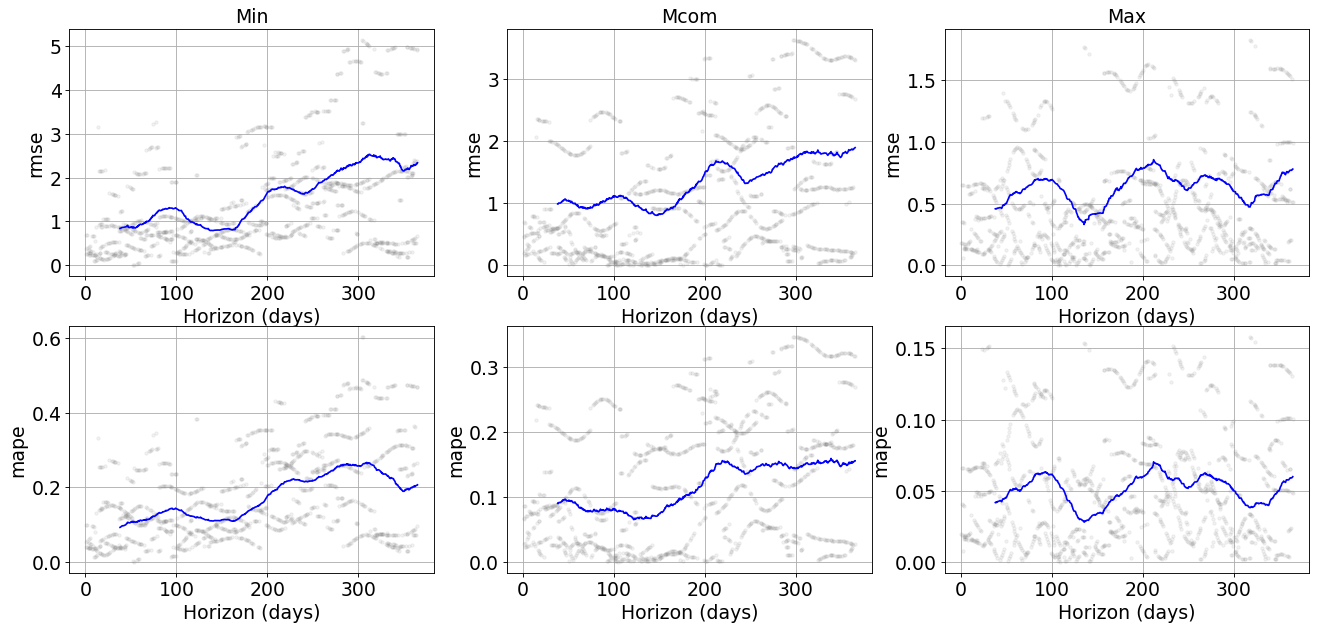

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(20,9), dpi= 80)
# Set general font size
plt.rcParams['font.size'] = '17'

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(17)
 
plot_cross_validation_metric(df_cvmin, metric='rmse',ax=axes[0,0])
axes[0,0].set_title('Min', fontsize = 17)
axes[0,0].set_ylabel('rmse', fontsize = 17)
axes[0,0].set_xlabel('Horizon (days)', fontsize = 17)
plot_cross_validation_metric(df_cvmc, metric='rmse',ax=axes[0,1])
axes[0,1].set_title('Mcom', fontsize = 17)
axes[0,1].set_ylabel('rmse', fontsize = 17)
axes[0,1].set_xlabel('Horizon (days)', fontsize = 17)
plot_cross_validation_metric(df_cv, metric='rmse',ax=axes[0,2])
axes[0,2].set_title('Max', fontsize = 17)
axes[0,2].set_ylabel('rmse', fontsize = 17)
axes[0,2].set_xlabel('Horizon (days)', fontsize = 17)
plot_cross_validation_metric(df_cvmin, metric='mape',ax=axes[1,0])
axes[1,0].set_ylabel('mape', fontsize = 17)
axes[1,0].set_xlabel('Horizon (days)', fontsize = 17)
plot_cross_validation_metric(df_cvmc, metric='mape',ax=axes[1,1])
axes[1,1].set_ylabel('mape', fontsize = 17)
axes[1,1].set_xlabel('Horizon (days)', fontsize = 17)
plot_cross_validation_metric(df_cv, metric='mape',ax=axes[1,2])
axes[1,2].set_ylabel('mape', fontsize = 17)
axes[1,2].set_xlabel('Horizon (days)', fontsize = 17)
;
plt.savefig('rmsemape3.jpg',dpi=400)

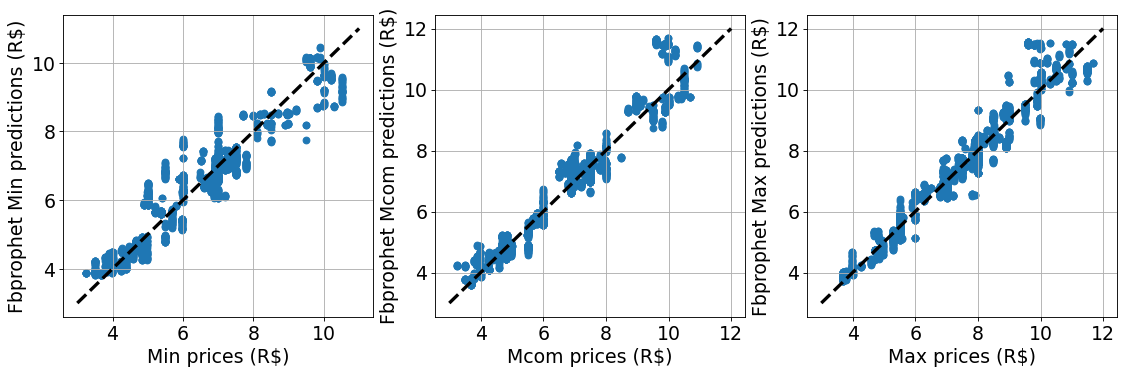

In [53]:
range_linemin = int(np.maximum(max(dfmin['y']), max(y_predmin)))+2
range_linemc = int(np.maximum(max(dfmc['y']), max(y_predmcom)))+2
range_linem = int(np.maximum(max(dfm['y']), max(y_predm)))+2

# Set general font size
plt.rcParams['font.size'] = '17'

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(15)

fig, axes = plt.subplots(1, 3, figsize=(17,5), dpi= 80)
axes[0].scatter(dfmin['y'], y_predmin)
axes[0].plot(range(3, range_line), range(3, range_line), '--', c='black', lw=3)
axes[0].set_ylabel('Fbprophet Min predictions (R$)',fontsize = 17)
axes[0].set_xlabel('Min prices (R$)',fontsize = 17)
axes[0].grid()
axes[1].scatter(dfmc['y'], y_predmcom)
axes[1].plot(range(3, range_linemc), range(3, range_linemc), '--', c='black', lw=3)
axes[1].set_ylabel('Fbprophet Mcom predictions (R$)',fontsize = 17)
axes[1].set_xlabel('Mcom prices (R$)',fontsize = 17)
axes[1].grid()
axes[2].scatter(dfm['y'], y_predm)
axes[2].plot(range(3, range_linem), range(3, range_linem), '--', c='black', lw=3)
axes[2].set_ylabel('Fbprophet Max predictions (R$)',fontsize = 17)
axes[2].set_xlabel('Max prices (R$)',fontsize = 17)
axes[2].grid()
plt.savefig('prophetqq4.jpg',dpi=400)